# Preparing Iphone health data 

Health and activity were taken from iphone for one person only. the exported file is in XML file.
Below code uses BeautifulSoup to scrap step counts.


In [56]:
import pandas as pd
import sys 
import numpy as np 
from bs4 import BeautifulSoup as bs

In [24]:

content = []
# Read the XML file
with open("export.xml", "r") as file:
    # Read each line in the file, readlines() returns a list of lines
    content = file.readlines()
    # Combine the lines in the list into a string
    content = "".join(content)
    bs_content = bs(content, "lxml")

data =[]
for rec in bs_content.find_all(attrs={"type" : "HKQuantityTypeIdentifierStepCount"}):
    r = [rec['startdate'],rec['enddate'],rec['value']]
    data.append(r)

    
cols =['startdate','enddate','value']

df = pd.DataFrame(columns=cols,data = data )
#df.to_csv("")

,startdate,enddate,value
0,2018-06-02 18:59:25 +0300,2018-06-02 19:06:52 +0300,86
1,2018-06-02 19:37:34 +0300,2018-06-02 19:44:40 +0300,66
2,2018-06-02 21:01:04 +0300,2018-06-02 21:07:09 +0300,8
3,2018-06-02 21:40:05 +0300,2018-06-02 21:47:47 +0300,9
4,2018-06-02 21:55:05 +0300,2018-06-02 22:05:00 +0300,194
...,...,...,...
31111,2021-09-19 17:24:13 +0300,2021-09-19 17:24:16 +0300,12
31112,2021-09-19 17:49:35 +0300,2021-09-19 17:50:39 +0300,24
31113,2021-09-19 18:19:58 +0300,2021-09-19 18:21:28 +0300,91
31114,2021-09-19 18:45:40 +0300,2021-09-19 18:48:14 +0300,121


# processing and quality check

In [60]:
# 

df['date'] = pd.to_datetime(df['date'])
df.sort_values('date',inplace=True)
# calculate gaps in days between records
df['Days_gap'] = df.date.diff().astype('timedelta64[D]')
#df['Days_gap'].sort_values('Days_gap',ascending=False).head(10)


df['hour'] = df.date.dt.hour
df.drop_duplicates("date")



#parse start time and end time
df['startdate'] = pd.to_datetime(df['startdate'])
df['enddate'] = pd.to_datetime(df['enddate'])
df['value'] =pd.to_numeric(df['value'])
#calculate the interval of each record
df['duration'] = (df['enddate']-df['startdate']).astype('timedelta64[s]')

#extract date only for grouping, start hour and end hour for interpolation 
df['date'] = df['startdate'].dt.date
df['start_hour'] = df['startdate'].dt.hour
df['end_hour'] = df['enddate'].dt.hour

#calculate days between records to check for gaps
df.sort_values('startdate',inplace=True)
df['days_gap'] = (df['startdate'].diff()).astype('timedelta64[D]')
df['days_gap'] = df['days_gap'].fillna(0)

# Hours_gap to check period of inactivity, which could indicate the person is sleeping
df['Hours_gap'] = (df['startdate'].diff()).astype('timedelta64[h]')





#check need for interpolation
print("There are ",df[df['end_hour']!=df['start_hour']].shape[0], 'records that need interpolation')
print("There are ",df[(df['end_hour']==0) & (df['start_hour']==23)].shape[0],' records that ended on next day ')
print(max(df['days_gap'])," maximum days gap in data") 


# since the maximum interval for each record is 10 minutes, there will be no impact if we take the value to starting time.



There are  3633 records that need interpolation
There are  190  records that ended on next day 
0.0  maximum days gap in data


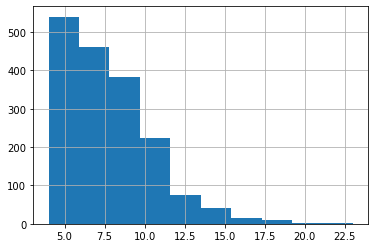

In [64]:
# check periods of inactivities
df[df['Hours_gap']>3].Hours_gap.hist()



In [81]:
# taking the maximum period of inactivity in a day as sleep duration
Daily_Sleep_Duration = df.groupby('date').agg({"Hours_gap":np.max})

In [94]:
df[(df['startdate']>='2018-06-02')& (df['startdate']<'2018-06-04') ]
Daily_Sleep_Duration = Daily_Sleep_Duration.reset_index()

In [119]:
# create a new dataframe for sleep records. 
# Wake up time would be the starttime of activity after the largest period of inacitivity
# sleeping time would be the endtime of last activity record before that
Sleep_Schedule = pd.DataFrame(columns=["Date","Slept_On","WokeUp_On","Duration"])
def getSleepRecords(x):
    #find start time as wokeup, if duplicates found , get the first one
    wokeup = df[(df['date']==x['date']) &(df['Hours_gap']==x['Hours_gap'])].startdate.values[0]
    #print(wokeup)
    Sleep_Schedule.loc[-1] = [x['date'], np.nan, wokeup,x['Hours_gap']]  # adding a row
    Sleep_Schedule.index = Sleep_Schedule.index + 1  # shifting index
    #df = df.sort_index() 
#get rows with NAN
#delete first record
df[df.isna().any(axis=1)]
#df.drop(0,inplace=True)

#apply lambda , for each day in daily_sleep_duration get the starting row 
Daily_Sleep_Duration.apply(lambda x:getSleepRecords(x),axis=1)

Sleep_Schedule['Woke_Hour'] = Sleep_Schedule.WokeUp_On.dt.hour


Sleep_Schedule.to_csv("Sleep_Schedule.csv")


In [27]:
#min_date = min(df['date']).strftime('%Y-%m-%d')
#max_date = max(df['date']).strftime('%Y-%m-%d')
#print(min_date,max_date)
#max_date
#date_range = pd.date_range(start=min_date,end=max_date)


In [28]:
df.head()

,startdate,enddate,value,duration,date,start_hour,end_hour,days_gap
0,2018-06-02 18:59:25+03:00,2018-06-02 19:06:52+03:00,86,447.0,2018-06-02,18,19,0.0
1,2018-06-02 19:37:34+03:00,2018-06-02 19:44:40+03:00,66,426.0,2018-06-02,19,19,0.0
2,2018-06-02 21:01:04+03:00,2018-06-02 21:07:09+03:00,8,365.0,2018-06-02,21,21,0.0
3,2018-06-02 21:40:05+03:00,2018-06-02 21:47:47+03:00,9,462.0,2018-06-02,21,21,0.0
4,2018-06-02 21:55:05+03:00,2018-06-02 22:05:00+03:00,194,595.0,2018-06-02,21,22,0.0


In [30]:
# aggregate daily steps and save it 
df_daily = df.groupby("date")["value"].sum().reset_index()


df_daily = df_daily[['date','value']]
df_daily.columns= ['Date','Steps']
df_daily.to_csv('steps.csv')


,date,value
0,2018-06-02,3140
1,2018-06-03,9810
2,2018-06-04,6551
3,2018-06-05,6107
4,2018-06-06,2569
...,...,...
1202,2021-09-16,4454
1203,2021-09-17,3702
1204,2021-09-18,3939
1205,2021-09-19,2847


Maha
